In [1]:
from PIL import Image
import numpy as np
import pandas as pd

# Show/Check Img 

In [2]:
# 在PIL中，使用Image模块的open()函数打开后，返回的图像对象的模式都是“RGB”
# The images have to be loaded in to a range of [0, 1] and then normalized using 
ch_mean = np.array([0.485, 0.456, 0.406])
ch_std = np.array([0.229, 0.224, 0.225])
def scale_fn(x): 
    # 0-255 to 0-1
    x = np.clip( x/255.0 , 0, 1)
    # RGB normalize
    assert len(x.shape)>=3 and x.shape[-1]==3
    x = (x - ch_mean)/ch_std
    return x

def rescale_fn(x):
    # RGB de-normalize
    assert len(x.shape)>=3 and x.shape[-1]==3
    x = x*ch_std + ch_mean
    # 0-1 to 0-255 
    x = np.clip( x*255.0 , 0, 255).astype('uint8')
    return x

f = "01F03AFBFF"
#f = "006F8606F6"
f = f"./testing_set/testing_set/{f}.png"
img = np.array(Image.open(f))
print(img.max(), img.min(), img.mean(), img.std())
img = scale_fn(img)
print(img.max(), img.min(), img.mean(), img.std())
img = rescale_fn(img)
print(img.max(), img.min(), img.mean(), img.std())

234 12 115.81043333333334 42.81419264982895
2.273986928104575 -1.7906162464985995 0.022104269818202717 0.7253857003537688
234 12 115.78803888888889 42.848503607200406


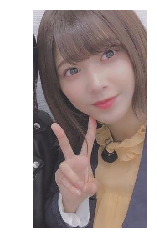

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(img_data, rescale=False):
    if rescale:
        img_data = rescale_fn(img_data)
    plt.axis('off')
    imgplot = plt.imshow(img_data)
    plt.show()

show_img(img)

# Face Detection Module

In [4]:
import dlib
predictor_path = "shape_predictor_68_face_landmarks.dat"
face_rec_model_path = "dlib_face_recognition_resnet_model_v1.dat"
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor(predictor_path)
facerec = dlib.face_recognition_model_v1(face_rec_model_path)

In [5]:
def get_face_discribe_dim128(img_data, det): #取得臉部特徵向量
    shape = sp(img_data, det)
    face_discrib = np.array(facerec.compute_face_descriptor(img_data, shape)) 
    return face_discrib

In [6]:
def find_center_det(dets, img_h, img_w): # img_h: image height, img_w: image width
    assert len(dets)>0
    min_dist = 9999
    c = (img_w/2, img_h/2)
    best_d = dets[0] #init
    for d in dets:
        c_ = d.center()
        dist = ((c_.x-c[0])**2+(c_.y-c[1])**2)**0.5
        if dist < min_dist:
            min_dist = dist
            best_d = d  
    return best_d

In [7]:
# 當偵測到多張臉, 選取最中間的那張臉
f = "093"
f = f"./training_set/training_set/neru/{f}.png"
img = np.array(Image.open(f))
dets = detector(img, 1)
print("All detections: ", dets)
d = dets[0] # [(left, top) (right, bottom)]
print( "The first detection: top={}, bottom={}, left={}, right={}, center_x={}, center_y={} "
      .format( d.top(), d.bottom(), d.left(), d.right(), d.center().x, d.center().y ) )
h, w = img.shape[0], img.shape[1]
d = find_center_det(dets, h, w)
print( "The BEST detection: top={}, bottom={}, left={}, right={}, center_x={}, center_y={} "
      .format( d.top(), d.bottom(), d.left(), d.right(), d.center().x, d.center().y ) )

All detections:  rectangles[[(535, 396) (578, 439)], [(253, 253) (408, 408)]]
The first detection: top=396, bottom=439, left=535, right=578, center_x=557, center_y=418 
The BEST detection: top=253, bottom=408, left=253, right=408, center_x=331, center_y=331 


In [8]:
def expand_box(det ,img_h, img_w, expand_ratio=1.5):
    t,b,l,r =  det.top(), det.bottom(), det.left(), det.right()
    box_h, box_w = b-t, r-l
    center_x, center_y = det.center().x, det.center().y 
    box_h, box_w = expand_ratio*box_h, expand_ratio*box_w
    t,b,l,r = int(center_y-box_h/2), int(center_y+box_h/2), int(center_x-box_w/2), int(center_x+box_w/2)
    t,b,l,r = max(t,0), min(b,img_h), max(l,0), min(r,img_w)#不應超過圖像範圍
    return t,b,l,r

t,b,l,r = expand_box(d ,h, w, expand_ratio=1.0)
print("expand_ratio=1.0 時的邊界(與原本偵測到的範圍相同): ", t,b,l,r)
t,b,l,r = expand_box(d ,h, w, expand_ratio=1.5)
print("expand_ratio=1.5 時的邊界(比偵測到的範圍大一些): ", t,b,l,r)
t,b,l,r = expand_box(d ,h, w, expand_ratio=100)
print("expand_ratio太大 時的邊界(同影像原圖邊界): ", t,b,l,r)

expand_ratio=1.0 時的邊界(與原本偵測到的範圍相同):  253 408 253 408
expand_ratio=1.5 時的邊界(比偵測到的範圍大一些):  214 447 214 447
expand_ratio太大 時的邊界(同影像原圖邊界):  0 640 0 640


In [9]:
def face_detection(img_data, do_crop=False, 
                   do_expand_box=False, expand_ratio=1.5,
                   return_face_discrib=False,
                  ):
    dets = detector(img_data, 1)#偵測是否存在人臉
    img_h, img_w = img_data.shape[0], img_data.shape[1]
    if len(dets)>0:
        det = find_center_det(dets, img_h, img_w) 
        # 取得臉部特徵描述
        face_discrib = None
        if return_face_discrib: face_discrib = get_face_discribe_dim128(img_data, det)
        # 取得擴張後box範圍
        if not do_expand_box: expand_ratio=1.0
        t,b,l,r = expand_box(det ,img_h, img_w, expand_ratio=expand_ratio)  
        #執行截圖
        if do_crop: img_data = img_data[t:b,l:r] 
        return img_data, (t,b,l,r), True, face_discrib
    else:
        #print("No face detected!")  
        return img_data, (0,img_h,0,img_w), False, None
    
img_data, coord, is_detected, _ = face_detection(img, do_crop=False,do_expand_box=False)
print( "原圖:", is_detected, img_data.shape )
img_data, coord, is_detected, _ = face_detection(img, do_crop=True,do_expand_box=False)
print( "Crop: ", is_detected, img_data.shape )
img_data, coord, is_detected, _ = face_detection(img, do_crop=True,do_expand_box=True, expand_ratio=2.0)
print( "Expand Crop: ",is_detected, img_data.shape )
img_data, coord, is_detected, _ = face_detection(img, do_crop=True,do_expand_box=True, expand_ratio=100.0)
print( "極度Expand的 Crop(原圖): ",is_detected, img_data.shape )

原圖: True (640, 640, 3)
Crop:  True (155, 155, 3)
Expand Crop:  True (310, 310, 3)
極度Expand的 Crop(原圖):  True (640, 640, 3)


In [10]:
_, _, is_detected, face_discrib = face_detection(img, 
                                                 return_face_discrib=True,
                                                )
print( "臉部特徵向量: ", is_detected, ",", face_discrib.shape )

臉部特徵向量:  True , (128,)


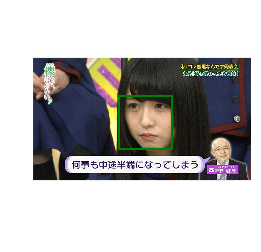

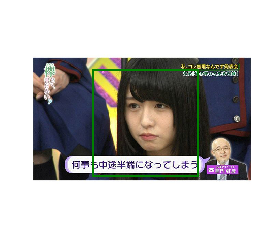

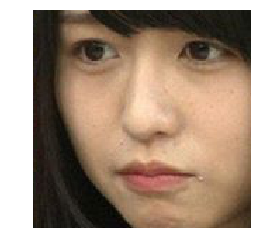

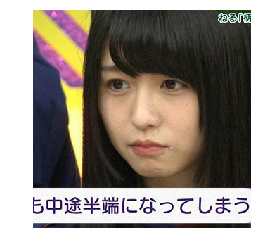

In [11]:
import matplotlib.patches as patches

def show_img_with_detection(img_data, rescale=False, do_crop=False, 
                            do_expand_box=False, expand_ratio=1.5):
    if rescale:
        img_data = rescale_fn(img_data)
    plt.axis('off')
    img_data, coord, is_detected, _ = face_detection(img_data, do_crop=do_crop, 
                                                     do_expand_box=do_expand_box,
                                                     expand_ratio=expand_ratio)
    if is_detected and (not do_crop):  
        ax = plt.gca()
        t,b,l,r = coord
        # Create a Rectangle patch
        rect = patches.Rectangle((l,t),r-l,b-t,linewidth=2,edgecolor='g',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    imgplot = plt.imshow(img_data)
    plt.show()
    
show_img_with_detection(img, do_crop=False,do_expand_box=False)
show_img_with_detection(img, do_crop=False,do_expand_box=True, expand_ratio=2.0)
show_img_with_detection(img, do_crop=True)
show_img_with_detection(img, do_crop=True,do_expand_box=True, expand_ratio=2.0)

# Load Data

In [12]:
%%time
from os import listdir
from os.path import isfile, isdir, join

img_size = 224

def get_imgs_data(mypath, 
                  skip_file_names = [],
                  return_file_names=False, 
                  do_crop=True, 
                  return_face_discrib=True,
                  print_not_detected=False,
                 ):
    
    files = listdir(mypath) # 取得所有檔案與子目錄名稱
    for f in skip_file_names:
        files.remove(f'{f}.png')
        print(f"Remove [{mypath}{f}.png]")
        
    imgs_arr = []
    file_names = []
    face_discribes = []
    not_detected_count = 0
    for f in files:
        if (not f[0]=='.') and (f[-4:]=='.png'):
            img = Image.open(mypath+f)
            img_data = np.array(img)
            img_data, coord, is_detected, face_discrib \
            = face_detection( img_data, 
                              do_crop=do_crop,
                              do_expand_box=True, 
                              expand_ratio=2.0,
                              return_face_discrib=True )
            if (not is_detected):
                not_detected_count += 1
            if print_not_detected and (not is_detected):
                print(f"[{mypath}{f}] NO face detected!")
                
            img = Image.fromarray(img_data).resize((img_size, img_size), Image.ANTIALIAS)
            imgs_arr.append(np.array(img))
            file_names.append(f[:-4])
            face_discribes.append(face_discrib)
    
    print("NO face detected ratio : {:.2f}".format(not_detected_count/len(files) ))
    op_array =  scale_fn( np.array(imgs_arr) ) 
    if return_file_names:
        return op_array , file_names, face_discribes
    return op_array, face_discribes

X_test, ids_test_list, FD_test_list = get_imgs_data("./testing_set/testing_set/", 
                                          return_file_names=True, 
                                          print_not_detected=False) 
print(X_test.shape)
ids_test[:5]

NO face detected ratio : 0.18
(438, 224, 224, 3)
CPU times: user 2min 10s, sys: 1.58 s, total: 2min 12s
Wall time: 2min 21s


In [13]:
classmap = pd.read_csv('classmap.csv', index_col=0, header=0).to_dict()['classnum']
classmap

{'rika': 0, 'risa': 1, 'yui': 2, 'akane': 3, 'neru': 4}

In [14]:
deleted_train_id = {    0: [],
                        1: ['061'],
                        2: ['020','045','031','070'],
                        3: ['058', '027'],
                        4: ['101','044'] }

In [15]:
%%time
X_train_list = [] 
ids_train_list = []
y_train_list = []
FD_train_list = []

for k in classmap.keys():
    print("*"*64)
    c_i =  classmap[k]
    skip_file_names = deleted_train_id[c_i]
    X_train_, ids_train, FD_train_ = get_imgs_data(f"./training_set/training_set/{k}/",
                                                   skip_file_names=skip_file_names,
                                                   return_file_names=True)
    print(f"class [{c_i}]: ", X_train_.shape)
    X_train_list.append(X_train_)
    y_train_list.append(np.zeros(X_train_.shape[0])+c_i)
    ids_train_list += ids_train
    FD_train_list += FD_train_
    
X_train = np.concatenate(X_train_list, 0); print(f"X_train: ", X_train.shape)
y_train = np.concatenate(y_train_list, 0); print(f"y_train: ", y_train.shape)
print(len(FD_train_list))
del X_train_list; del y_train_list

NO face detected ratio : 0.34
class [0]:  (100, 224, 224, 3)
Remove [./training_set/training_set/risa/061.png]
NO face detected ratio : 0.18
class [1]:  (101, 224, 224, 3)
Remove [./training_set/training_set/yui/020.png]
Remove [./training_set/training_set/yui/045.png]
Remove [./training_set/training_set/yui/031.png]
Remove [./training_set/training_set/yui/070.png]
NO face detected ratio : 0.23
class [2]:  (110, 224, 224, 3)
Remove [./training_set/training_set/akane/058.png]
Remove [./training_set/training_set/akane/027.png]
NO face detected ratio : 0.07
class [3]:  (105, 224, 224, 3)
Remove [./training_set/training_set/neru/101.png]
Remove [./training_set/training_set/neru/044.png]
NO face detected ratio : 0.27
class [4]:  (113, 224, 224, 3)
X_train:  (529, 224, 224, 3)
y_train:  (529,)
529
CPU times: user 1min 34s, sys: 1.57 s, total: 1min 36s
Wall time: 1min 48s


# Save

In [17]:
np.save("data/X_train", X_train)
np.save("data/y_train", y_train)
np.save("data/X_test", X_test)
np.save("data/ids_train", ids_train_list)
np.save("data/ids_test", ids_test_list)

In [18]:
import pickle

In [19]:
pickle.dump(FD_train_list, open("data/FD_train_list.pkl", "wb") )
pickle.dump(FD_test_list, open("data/FD_test_list.pkl", "wb") )